In [1]:
import builtins
import os
import sys
import time
import argparse
import socket
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets

from PIL import ImageFilter

import models.resnet as resnet

In [2]:
def parse_option():

    parser = argparse.ArgumentParser('argument for training')

    parser.add_argument('data', type=str, help='path to dataset')
    parser.add_argument('--dataset', type=str, default='imagenet',
                        choices=['imagenet', 'imagenet100'],
                        help='use full or subset of the dataset')
    parser.add_argument('--num_workers', type=int, default=12, help='num of workers to use')

    # model definition
    parser.add_argument('--arch', type=str, default='resnet18',
                        choices=['resnet18' , 'resnet50', 'mobilenet'])

    # ISD loss function
    parser.add_argument('--queue_size', type=int, default=128000)
    parser.add_argument('--temp', type=float, default=0.02)
    parser.add_argument('--momentum', type=float, default=0.999)

    parser.add_argument('--resume', default='', type=str,
                        help='path to latest checkpoint (default: none)')
    return parser

In [3]:
# Extended version of ImageFolder to return index of image too.
class ImageFolderEx(datasets.ImageFolder) :
    def __getitem__(self, index):
        sample, target = super(ImageFolderEx, self).__getitem__(index)
        return index, sample, target

In [4]:
# Transform the images twice: one for query encoder and the other for key encoder
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]


## Create the dataloader with two augmentations for each image

In [5]:
# Create train loader
def get_train_loader(opt):
    traindir = os.path.join(opt.data, 'train')
    image_size = 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = transforms.Normalize(mean=mean, std=std)

    # use less severe augmentation than in the actual code
    augmentation = [
        transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        transforms.RandomGrayscale(p=0.2),
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]


    train_dataset = ImageFolderEx(
        traindir,
        TwoCropsTransform(transforms.Compose(augmentation))
    )
    print('==> train dataset')
    print(train_dataset)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=256, shuffle=True,
        num_workers=12, pin_memory=True, drop_last=True)

    return train_loader

## Create the quey and key encoder models

In [6]:
class ISD(nn.Module):
    def __init__(self, arch, K=65536, m=0.999, T=0.07):
        super(ISD, self).__init__()

        self.K = K
        self.m = m
        self.T = T

        # create encoders and prediction layers
        if 'resnet' in arch:
            # both encoders should have same arch
            self.encoder_q = resnet.__dict__[arch]()
            self.encoder_k = resnet.__dict__[arch]()
            # save output embedding dimensions
            # assuming that both encoders have same dim
            feat_dim = self.encoder_q.fc.in_features
            out_dim = feat_dim

            ##### prediction layer ####
            # 1. have a prediction layer for q with BN
            self.predict_q = nn.Sequential(
                nn.Linear(feat_dim, feat_dim, bias=False),
                nn.BatchNorm1d(feat_dim),
                nn.ReLU(inplace=True),
                nn.Linear(feat_dim, feat_dim, bias=True),
            )

            ##### projection layers ####
            # 1. no projection layers for encoders
            self.encoder_k.fc = nn.Sequential()
            self.encoder_q.fc = nn.Sequential()
        else:
            raise ValueError('arch not found: {}'.format(arch))

        # copy query encoder weights to key encoder
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False


    @torch.no_grad()
    def data_parallel(self):
        self.encoder_q = torch.nn.DataParallel(self.encoder_q)
        self.encoder_k = torch.nn.DataParallel(self.encoder_k)
        self.predict_q = torch.nn.DataParallel(self.predict_q)

## Initialize the loader and the encoders

In [7]:
parser = parse_option()
args = parser.parse_args([
  '--num_workers', '16',
  '--resume', 'output/isd_1_t_020_augv2_lr_decay_140_180_epochs_200_resnet18/ckpt_epoch_200.pth',
  '/datasets/imagenet'
])

train_loader = get_train_loader(args)

# memory bank size is 128k
# momentum is 0.999
# and temperature is 0.02
isd = ISD('resnet18', K=128000, m=0.999, T=0.02)
isd.data_parallel()
isd = isd.cuda()

# resume from a checkpoint
if args.resume:
    print('==> resume from checkpoint: {}'.format(args.resume))
    ckpt = torch.load(args.resume)
    print('==> resume from epoch: {}'.format(ckpt['epoch']))
    sd = {k: v for k, v in ckpt['state_dict'].items() if 'queue' not in k}
    isd.load_state_dict(sd, strict=True)

# switch to eval mode
isd.eval()
for p in isd.parameters():
    p.requires_grad = False

==> train dataset
Dataset ImageFolderEx
    Number of datapoints: 1281167
    Root location: /datasets/imagenet/train
    StandardTransform
Transform: <__main__.TwoCropsTransform object at 0x7f6ab3bb72d0>
==> resume from checkpoint: output/isd_1_t_020_augv2_lr_decay_140_180_epochs_200_resnet18/ckpt_epoch_200.pth
==> resume from epoch: 200


## Fill up the queue with keys

In [8]:
# fill up the memory bank with keys
queue = []
all_indices = []

for idx, (indices, (im_q, im_k), _) in enumerate(train_loader):
    im_q = im_q.cuda(non_blocking=True)
    im_k = im_k.cuda(non_blocking=True)
   
    # calculate keys
    with torch.no_grad():
        k = isd.encoder_k(im_k)
        k = nn.functional.normalize(k, dim=1)
    
    # fill up 128k samples in the queue
    if (len(queue)*256) == 128000:
        break

    queue.append(k)
    all_indices.extend(indices.tolist())
    
# concatenate all keys
queue = torch.cat(queue, dim=0)
all_indices = torch.tensor(all_indices).int()

## Calculate the target (teacher) probabilities

In [9]:
# calculate similarities
sim_k = torch.mm(k, queue.t())

# scale with temp
sim_k /= isd.T

# calculate probabilities
targets = F.softmax(sim_k, dim=1)

In [10]:
sorted_probs, sort_inds = torch.sort(targets.cpu(), dim=1, descending=True)

In [11]:
val_t = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        transforms.RandomGrayscale(p=0.2),
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
        transforms.RandomHorizontalFlip(),
])
dset = ImageFolderEx('/datasets/imagenet/train', val_t)

In [12]:
sort_inds.shape

torch.Size([256, 128000])

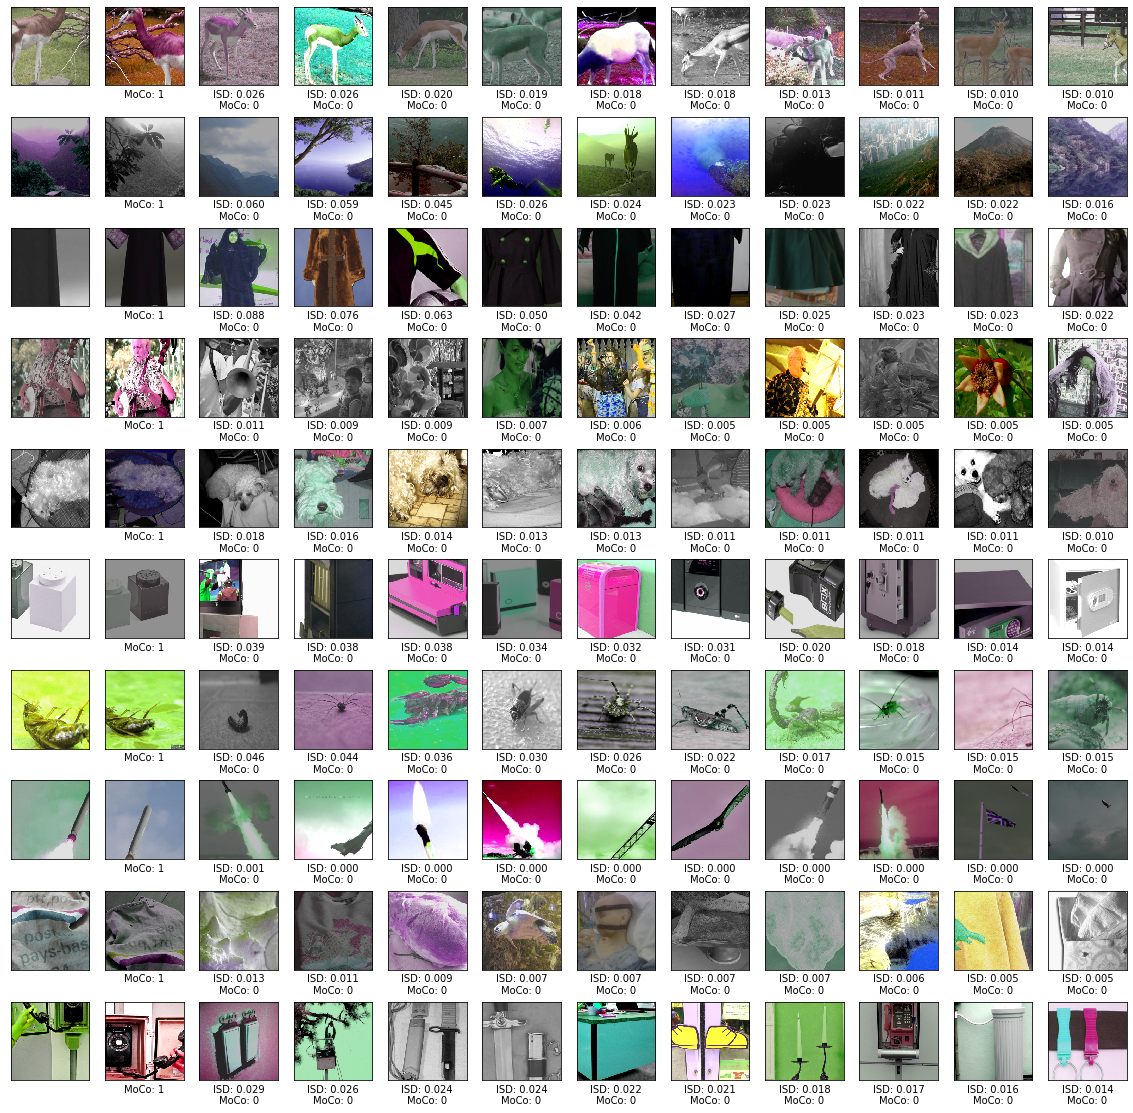

In [14]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(10,12, figsize=(20,20))
for row in range(10):
    axarr[row][0].imshow(dset[indices[row].item()][1])
    axarr[row][1].imshow(dset[indices[row].item()][1])
    axarr[row][0].set_xticks([])
    axarr[row][0].set_yticks([])
    axarr[row][1].set_xticks([])
    axarr[row][1].set_yticks([])
    axarr[row][1].set_xlabel('MoCo: 1')
    for col in range(2,12):
        axarr[row][col].imshow(dset[all_indices[sort_inds[row,col]].item()][1])
        axarr[row][col].set_xlabel('ISD: {:.3f}\nMoCo: 0'.format(sorted_probs[row,col].item()))
        axarr[row][col].set_xticks([])
        axarr[row][col].set_yticks([])
plt.show()